# Tutorial 3 : Use case example - Cloud classification

This notebook demonstrates cloud classification using a Random Forest algorithm through the OpenEO API. The Sentinel-2 dataset includes the Scene Classification Layer (SCL), which is simplified into three categories: background, cloud shadow, and cloud. The processed SCL is used as training data for the Random Forest model to predict clouds and cloud shadows. The trained model is then applied to test data.

This tutorial uses information from the [Random Forest based Classification and Regression](https://github.com/Open-EO/openeo-community-examples/blob/main/python/DynamicLandCoverMapping/Dynamic%20land%20cover%20mapping.ipynb) guide and the Jupyter notebook [Dynamic land cover mapping](https://open-eo.github.io/openeo-python-client/machine_learning.html) on OpenEO's Github.

In [72]:
#Imports
import openeo
import xarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openeo.processes import if_, and_
import rioxarray
import geopandas
import geojson
from openeo.rest.mlmodel import MlModel

Establish an authenticated connection to Copernicus Data Space Ecosystem openEO back-end.
For more information about back-end connection, check the *Tutorial 1 - Introduction*.

In [73]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

### Creating Datacube

Once connected to the OpenEO backend, we initialize a datacube object using the Sentinel-2 L2A data collection. We focus on the time period between May 1st and June 16th, 2023.

We select the spectral bands :
- B02 (Blue)
- B03 (Green)
- B04 (Red)
- B08 (Near Infrared)
- SCL (Scene Classification Layer)


In [74]:
# Get detailed description of one of them
connection.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html#sentinel-2-level-2a-top-of-canopy-toc',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2

The spectral coordinates that we gave corresponds to a small area in southern France, in the noth of Carcassonne as shown in the map below .

<div style="text-align: center;">
    <img src="images/tuto_classification/where.png" alt="" width="600"/>
</div>

In [75]:
s2_timeseries = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2023-05-01", "2023-06-16"),
    spatial_extent={
        "west":  2.213649,
        "south": 43.450702,
        "east": 2.251248,
        "north":  43.472631,
        "crs": "EPSG:4326",
    },
    bands=["B02", "B03", "B04", "B08", "SCL"],
    max_cloud_cover=50,
);

In [100]:
s2_timeseries

We will use the Scene Classification Layer (SCL) as a reference for our Random Forest classification.

This layer provides a classification of the Earth's surface that includes categories such as vegetation, water, clouds and cloud shadows.

The SCL classifications are described in detail on the Sentinel-2 Processing Wiki. The image bellow provides the different labels that are associated to each class of the SCL.

<div style="text-align: center;">
    <img src="images/tuto_classification/esa_class.png" alt="" width="600"/>
</div>

## Exporting and visualizing data

To vizualize the Sentinel-2 data we export it to the NetCDF format.

In [77]:
#Download the data to the NetCDF format
s2_timeseries.download("input/s2_timeseries.nc")

We can now load the dataset as an xarray. We can see that we have the requested bands "B02", "B03", "B04", "B08," and "SCL" for the time period provided, and the x and y coordinates of each point. 

In [78]:
# Load the Sentinel-2 time series dataset from a NetCDF file
s2_datarray = xarray.load_dataset("input/s2_timeseries.nc")

s2_datarray

<xarray.Dataset> Size: 8MB
Dimensions:  (t: 5, x: 308, y: 248)
Coordinates:
  * t        (t) datetime64[ns] 40B 2023-05-02 2023-05-17 ... 2023-06-04
  * x        (x) float64 2kB 4.364e+05 4.364e+05 ... 4.394e+05 4.394e+05
  * y        (y) float64 2kB 4.814e+06 4.814e+06 ... 4.811e+06 4.811e+06
Data variables:
    crs      |S1 1B b''
    B02      (t, y, x) float32 2MB 929.0 722.0 368.0 ... 8.64e+03 8.504e+03
    B03      (t, y, x) float32 2MB 1.244e+03 925.0 549.0 ... 8.224e+03 8.16e+03
    B04      (t, y, x) float32 2MB 1.38e+03 1.018e+03 ... 8.04e+03 7.984e+03
    B08      (t, y, x) float32 2MB 2.454e+03 2.366e+03 ... 8.464e+03 8.424e+03
    SCL      (t, y, x) float32 2MB 5.0 4.0 4.0 4.0 4.0 ... 9.0 9.0 9.0 9.0 9.0
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

We can now display the available dates in the dataset for the chosen time period.

Between May 1st and June 16th, and for the requested location, only 5 images have less than 50% cloud cover: May 2nd, 17th, 27th, 30th, and June 4th.

In [79]:
s2_datarray["t"]

<xarray.DataArray 't' (t: 5)> Size: 40B
array(['2023-05-02T00:00:00.000000000', '2023-05-17T00:00:00.000000000',
       '2023-05-27T00:00:00.000000000', '2023-05-30T00:00:00.000000000',
       '2023-06-04T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 40B 2023-05-02 2023-05-17 ... 2023-06-04
Attributes:
    standard_name:  t
    long_name:      t
    axis:           T

We plot the first  and the last image of the timeseries. The RGB bands and their corresponding SCL are plotted side by side.

[]

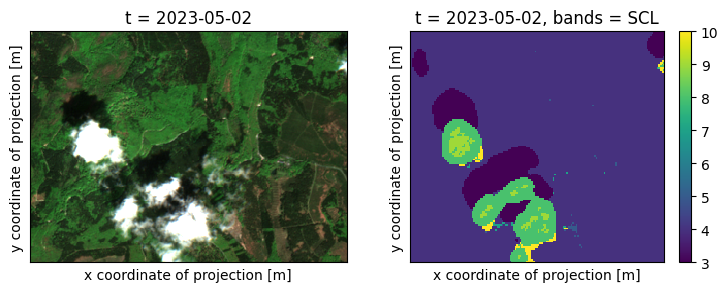

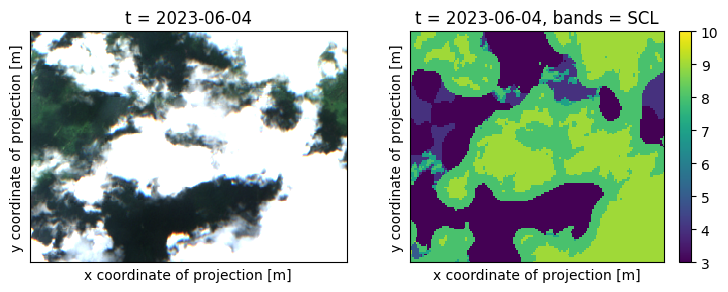

In [80]:
# Extract the SCL and the RGB bands as arrays to plot them
scl_arr = s2_datarray[["SCL"]].to_array(dim="bands")
rgb_arr = s2_datarray[["B04", "B03", "B02"]].to_array(dim="bands")

# Plotting the first image of the timeseries, and it's SCL band
fig, axes = plt.subplots(ncols=2, figsize=(9, 3), dpi=100, sharey=True)
#vmin and vmax are for the range of the colormap
rgb_arr[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
scl_arr[{"t": 0}].isel(bands=0).plot.imshow(vmin=3, vmax=10, ax=axes[1])
axes[1].set_xticks([])

# Plotting the last image of the timeseries, and it's SCL band
fig, axes = plt.subplots(ncols=2, figsize=(9, 3), dpi=100, sharey=True)
#vmin and vmax are for the range of the colormap
rgb_arr[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
scl_arr[{"t": -1}].isel(bands=0).plot.imshow(vmin=3, vmax=10, ax=axes[1])
axes[1].set_xticks([])

We display all the unique values contained in the SCL image to obtain more information about the classes contained in our data.

In [81]:
np.unique(scl_arr.isel(bands=0).values)

array([ 3.,  4.,  5.,  7.,  8.,  9., 10.], dtype=float32)

The SCL in the timeseries  contains seven classes : "Unclassified", "Cloud medium probability", "Thin cirrus", "Cloud high probability", "Cloud shadow", "Vegetation" and "Not vegetated". 

To simplify the SCL for our classification algorithm, we group these classes into three wider categories with the following labels:
- **3 : Background** – Combines "Vegetation," "Not vegetated," and "Unclassified".
- **4 : Cloud shadow** – Retains the original "Cloud shadow" class.
- **7 : Cloud** – Combines "Thin cirrus," "Cloud medium probability," and "Cloud high probability".

In [82]:
# Extracting classification band from the datacube
scl_band = s2_timeseries.band("SCL")

# The pixels that are above 7 are labeled as clouds
scl_labels = scl_band.apply(lambda x: if_(x > 7, 7, x))

# The pixels whose values are 4 or 5 are labeled as no clouds
scl_labels = scl_labels.apply(lambda x: if_(and_(x > 3, x < 6), 4, x))

In OpenEO, the *if_* and *and_* processes is are used to perform conditional operations on data. You can find a bit more information on these processes in the [Open EO API processes documentation](https://open-eo.github.io/openeo-python-client/api-processes.html#openeo.processes.if_). 

We export the modified SCL to the NetCDF format to visualize the changes. In the plot below, clouds appear turquoise, cloud shadows are dark blue and the background is medium blue.

In [83]:
#Download the modified SCL data to the NetCDF format
scl_labels.download("input/cloud_mask.nc")

[]

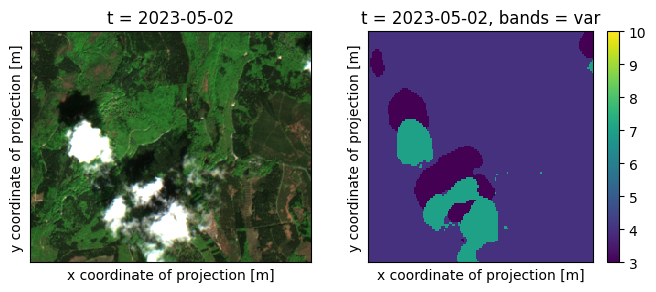

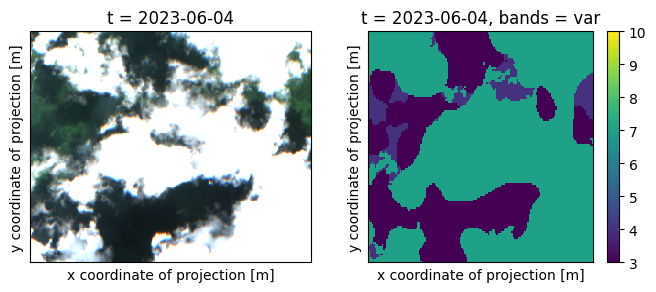

In [84]:
class_data = xarray.load_dataset("input/cloud_mask.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
scl_modif = class_data[["var"]].to_array(dim="bands")

# Plotting the first image of the timeseries, and it's SCL band
fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=100, sharey=True, sharex=True)
#vmin and vmax are for the range of the colormap
rgb_arr[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
scl_modif[{"t": 0}].isel(bands=0).plot.imshow(vmin=3, vmax=10, ax=axes[1])
axes[1].set_xticks([])

# Plotting the last image of the timeseries, and it's SCL band
fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=100, sharey=True, sharex=True)
#vmin and vmax are for the range of the colormap
rgb_arr[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
scl_modif[{"t": -1}].isel(bands=0).plot.imshow(vmin=3, vmax=10, ax=axes[1])
axes[1].set_xticks([])

We can confirm that only three categories remain in the modified SCL band by displaying all the unique values it contains.

In [85]:
np.unique(scl_modif.isel(bands=0).values)

array([3, 4, 7], dtype=int32)

## Building the training and test datasets

The image from May 2nd will be used for training, and the image from June 4th will be used for testing.

We select the corresponding image of the timeseries with the *.reduce_dimension()* method. We then download both files in the GeoTIFF format.

In [86]:
# Selecting the first temporal image for SCL
scl_train = scl_labels.reduce_dimension(dimension="t", reducer="first")

# Selecting RGB abd NIR bands
rgb_nir = s2_timeseries.filter_bands(["B02", "B03", "B04", "B08"])

# Selecting the first temporal image for RBG and NIR Bands
train_cube = rgb_nir.reduce_dimension(dimension="t", reducer="first")  

In [87]:
# Selecting the last temporal image for SCL
scl_test = scl_labels.reduce_dimension(dimension="t", reducer="last")

#Download the data to GeoTiff
scl_test.download("input/cloud_test.tiff", format="GTIFF")

# Selecting the last temporal image for RBG and NIR Bands
test_cube = rgb_nir.reduce_dimension(dimension="t", reducer="last")

### Building the feature collection

We load the provided GeoJSON file to create a FeatureCollection of labeled and georeferenced points for the training data. This GeoJSON file was generated by labeling specific points of the image for each class in QGIS and then exporting them as a GeoJSON file.


<div style="text-align: center;">
    <img src="images/tuto_classification/class_points.png" alt="" width="800"/>
</div>

In [ ]:
with open("cloud_class.geojson") as f:
    gj_data = geojson.load(f)

In [89]:
gj_data

{"crs": {"properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}, "type": "name"}, "features": [{"geometry": {"coordinates": [2.221382, 43.465292], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.218806, 43.465604], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.221382, 43.465994], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.228211, 43.459244], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.225518, 43.459009], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.250375, 43.471145], "type": "Point"}, "properties": {"id": null, "target": 3}, "type": "Feature"}, {"geometry": {"coordinates": [2.250609, 43.472199], "type": "Point"}, "properties": {"id": null, "target": 3}, "type":

## Training the Random Forest Model

We compute the mean of the B02/B03/B04/B08 band values of train_cube at the spatial points defined in *feature_collection*. We follow a similar process to the one outlined in [Dynamic land cover mapping Jupyter notebook](https://open-eo.github.io/openeo-python-client/machine_learning.html).

In [90]:
predictors = train_cube.aggregate_spatial(gj_data, reducer="mean")

We now train our Random Forest model and execute the training flow as a batch job.

In [91]:
#Configure the Training of the Random Forest Model
model = predictors.fit_class_random_forest(
    target=gj_data,
)

# Save the model as a batch job result asset so that we can load it in another job.
model = model.save_ml_model()

In [92]:
job_options = {
    "executor-memory": "3G",
    "executor-memoryOverhead": "4G",
}

In [93]:
# Running the job
training_job = model.create_job(
    title="Training-job Dynamic LC", job_options=job_options
)
training_job.start_and_wait()

0:00:00 Job 'j-25010638f86e492e8d77472d48726b40': send 'start'
0:00:15 Job 'j-25010638f86e492e8d77472d48726b40': created (progress 0%)
0:00:20 Job 'j-25010638f86e492e8d77472d48726b40': created (progress 0%)
0:00:26 Job 'j-25010638f86e492e8d77472d48726b40': created (progress 0%)
0:00:35 Job 'j-25010638f86e492e8d77472d48726b40': created (progress 0%)
0:00:44 Job 'j-25010638f86e492e8d77472d48726b40': created (progress 0%)
0:00:57 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:01:13 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:01:32 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:01:56 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:02:26 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:03:04 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:03:51 Job 'j-25010638f86e492e8d77472d48726b40': running (progress N/A)
0:04:49 Job 'j-25010638f86e492e8d77472d48726b40': running (progres

<BatchJob job_id='j-25010638f86e492e8d77472d48726b40'>

In [94]:
# Importing the results
results = training_job.get_results()
results.download_files()

[PosixPath('/home/ecadaux/Documents/work/pluto-tuto/DataAccess/OpenEO_tuto/randomforest.model.tar.gz'),
 PosixPath('/home/ecadaux/Documents/work/pluto-tuto/DataAccess/OpenEO_tuto/job-results.json')]

In [95]:
links = results.get_metadata()["links"]
ml_model_metadata_url = [
    link for link in links if "ml_model_metadata.json" in link["href"]
][0]["href"]
print(ml_model_metadata_url)

https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-25010638f86e492e8d77472d48726b40/results/items/NzRjYjFjYWItNTYxNi00MzA5LWE1MzYtMTkzNzE1N2I1Y2Y2/43233fed0f7579d523a6b1da7c046189/ml_model_metadata.json?expires=1736787192


In [96]:
# Loading the random Forest model
model = MlModel.load_ml_model(connection=connection, id=ml_model_metadata_url)

## Prediction of the test dataset

We can now predict the class of our test dataset with our trained model. The predictions are processed in batch and saved as GeoTIFF files.

In [98]:
predicted = (
    test_cube.predict_random_forest(model=model, dimension="bands")
) 
test_job = predicted.execute_batch(
    out_format="GTiff", title="cloud prediction"
)
test_job.get_results().download_files(target="output")

0:00:00 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': send 'start'
0:00:21 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:00:26 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:00:33 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:00:41 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:00:51 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:01:03 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:01:19 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:01:38 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:02:02 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:02:32 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': created (progress 0%)
0:03:10 Job 'j-2501063a7b5542fda2ff34d3d0eb4346': finished (progress 100%)


[PosixPath('output/openEO.tif'), PosixPath('output/job-results.json')]

## Plotting the result

We finally plot the random forest prediction and compare it to the reference SCL data.

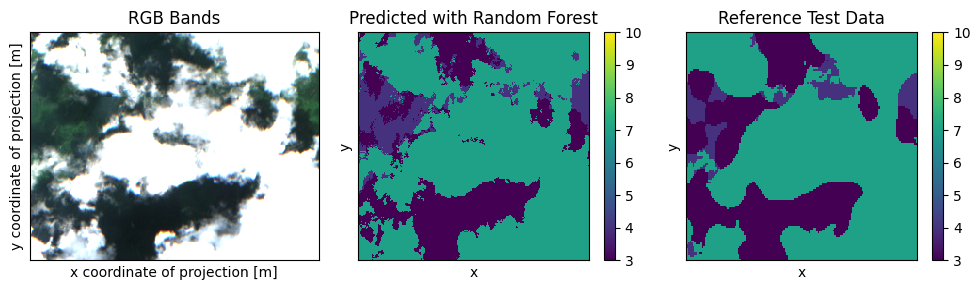

In [99]:
predicted_test = rioxarray.open_rasterio('openEO.tif')
ref_test = rioxarray.open_rasterio('input/cloud_test.tiff')

fig, axes = plt.subplots(ncols=3, figsize=(10, 3), dpi=100, sharey=True, sharex=True)
#vmin and vmax are for the range of the colormap
rgb_arr[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("RGB Bands")
predicted_test.isel(band=0).plot.imshow(vmin=3, vmax=10, ax=axes[1])
axes[0].set_xticks([])
axes[1].set_title("Predicted with Random Forest")
ref_test.isel(band=0).plot.imshow(vmin=3, vmax=10, ax=axes[2])
axes[2].set_title("Reference Test Data")
axes[2].set_xticks([])
plt.tight_layout()